# BLAST score distributions between Swiss-Prot variants

In [3]:
using Plots
include("source/io.jl")
include("source/utils.jl")
include("source/derangement.jl")
include("source/alignment.jl")
include("source/blast.jl")

search (generic function with 1 method)

### Shuffling and reversing 
The command `esl-shuffle input.fa > output.fa` shuffles each sequence in a FASTA record in `input.fa` and writes to `output.fa`. Using the `-r` flag, `esl-shuffle -r input.fa > output.fa` reverses each sequence. Generate the shuffled and reversed variants using EASEL.

```
esl-shuffle data/sprot.fa > data/shuf_sprot.fa
esl-shuffle -r data/sprot.fa > data/rev_sprot.fa
esl-shuffle -r data/shuf_sprot.fa > data/rev_shuf_sprot.fa

esl-shuffle data/sprot_scop.fa > data/shuf_sprot_scop.fa
esl-shuffle data/sprot_scop.fa -r > data/rev_sprot_scop.fa
esl-shuffle -r data/shuf_sprot_scop.fa > data/rev_shuf_sprot_scop.fa
```

Alternatively, generate the variants using Julia.

In [4]:
sprot = readsequences("data/sprot.fa")
rev_sprot = reverse.(sprot)
writesequences("data/rev_sprot.fa", rev_sprot)
shuf_sprot = shufflefast.(sprot)
writesequences("data/shuf_sprot.fa", shuf_sprot)
rev_shuf_sprot = reverse.(shuf_sprot)
writesequences("data/rev_shuf_sprot.fa", rev_shuf_sprot)

In [5]:
sprot_scop = readsequences("data/sprot_scop.fa")
rev_sprot_scop = reverse.(sprot_scop)
writesequences("data/rev_sprot_scop.fa", rev_sprot_scop)
shuf_sprot_scop = shufflefast.(sprot_scop)
writesequences("data/shuf_sprot_scop.fa", shuf_sprot_scop)
rev_shuf_sprot_scop = reverse.(shuf_sprot_scop)
writesequences("data/rev_shuf_sprot_scop.fa", rev_shuf_sprot_scop)

### Classify Swiss-Prot sequences by their SCOP2 fold
Download the SCOP2 classification table.

```
cd data
wget http://scop.mrc-lmb.cam.ac.uk/files/scop-cla-latest.txt
```

If the cells for Figure 1 have not yet been run, run them now. The following cell requires `outputs/sprot_by_scop2sf.df`.

Pair each sequence in `data/sprot_scop.fa` to its SCOP2 superfamily representative. Assign the Swiss-Prot sequence the fold of its SCOP2 superfamily representative and store these in a CSV.

In [ ]:
scoptable = readscopclass("data/scop-cla-latest.txt")
foldlookup = Dict(Pair.(parse.(Int, scoptable."SF-DOMID"), scoptable."CF"));
sprot_scop_registration = readframe("outputs/sprot_scop_registration.df")
sprot_scop_registration."fold" = [foldlookup[scopid] for scopid=sprot_scop_registration."scop-id"]
writeframe("outputs/sprot_scop_registration.df", sprot_scop_registration)

### Construct a derangement of the SCOP2 SF fold classification of Swiss-Prot.
A derangement is a permutation that has no fixed points: **(1, 2, 3, 4) -> (3, 1, 4, 2)** is a derangement; **(1, 2, 3, 4) -> (3, 2, 4, 1)** is not. 

Construct a derangement $\rho$ with respect to the fold classification such that all pairs of sequences $(s_i, s_{\rho(i)})$ between Swiss-Prot and its reordering have distinct folds.

In [ ]:
sprot_scop_registration = readframe("outputs/sprot_scop_registration.df")
# the derangement is constructed from a vector of integers.
# assign indices to each fold identified with a Swiss-Prot sequence. 
unique_folds = unique(sprot_scop_registration."fold")
indexlookup = Dict(Pair.(unique_folds, 1:length(unique_folds)))
# then generate a vector of integers mapping sprot_scop index to fold index.
sprot_scop_fold_indices = [indexlookup[fold] for fold=sprot_scop_registration."fold"]
# construct a deragenment of the sprot_scop fold sequence.
ρ = derangement(sprot_scop_fold_indices, weighted=true)
# and permute sprot by the same derangement.
sprot = readfasta("data/sprot.fa")
sprot_scop = [sprot[i] for i=sprot_scop_registration."sprot-index"]
reorder_sprot_scop = sprot_scop[ρ]
writefasta("data/reorder_sprot_scop.fa", reorder_sprot_scop)

### Paired alignment with BLAST
With each variant constructed, run the full experiment structure using the Julia wrapper for `BLAST`.

<img src="assets/diagram.png" width=500 alt="The words sprot, shuf, rev, shufrev, and random are drawn in print. Four lines are drawn between these words, representing paired alignment between the sequence sets. A purple line connects sprot to random. A blue line connects sprot to rev. An orange line connects shuf to sprot. A red line connects shuf to shufrev."/>

In [5]:
queries = [
    "data/sprot_scop.fa", 
    "data/sprot_scop.fa", 
    "data/sprot_scop.fa", 
    "data/shuf_sprot_scop.fa"]
references = [
    "data/reorder_sprot_scop.fa", 
    "data/shuf_sprot_scop.fa", 
    "data/rev_sprot_scop.fa", 
    "data/rev_shuf_sprot_scop.fa"]
name(x) = split(split(x, '/')[2], '.')[1]
querynames = name.(queries)
referencenames = name.(references)
resultnames = ["$(qname)↔$(rname)" for (qname, rname)=zip(querynames, referencenames)]
resultpaths = ["data/$(name).dlm" for name=resultnames]

4-element Vector{String}:
 "data/sprot_scop↔reorder_sprot_scop.dlm"
 "data/sprot_scop↔shuf_sprot_scop.dlm"
 "data/sprot_scop↔rev_sprot_scop.dlm"
 "data/shuf_sprot_scop↔rev_shuf_sprot_scop.dlm"

In [ ]:
# this takes a while!
results = search.([Pairwise()], queries, references; verbose=true, careful=true, ntasks=12)
for i=1:length(resultpaths)
    result_table = parse_blastp(results[i])
    writeframe(resultpaths[i], DataFrame(result_table, BLASTP_COLUMNS))
end

## Plot

In [6]:
using Plots
using FASTX
include("source/io.jl")
include("source/utils.jl")
function fig2plot!(x, label, color)
    stephist!(x, label=label, color=color, bins=1:80)
end
colors = ["purple", "orange", "blue", "red"]
results = readframe.(resultpaths)
scores = [frame.score for frame=results]

4-element Vector{Vector{Int64}}:
 [28, 27, 41, 35, 33, 31, 20, 30, 28, 23  …  28, 35, 27, 32, 30, 37, 37, 34, 34, 34]
 [20, 37, 33, 33, 29, 24, 26, 21, 23, 22  …  29, 29, 45, 44, 42, 42, 42, 41, 41, 40]
 [44, 25, 24, 24, 21, 47, 43, 42, 41, 38  …  60, 58, 47, 46, 45, 43, 41, 41, 41, 39]
 [25, 24, 23, 20, 80, 44, 44, 44, 44, 42  …  40, 40, 40, 40, 40, 40, 40, 40, 40, 39]

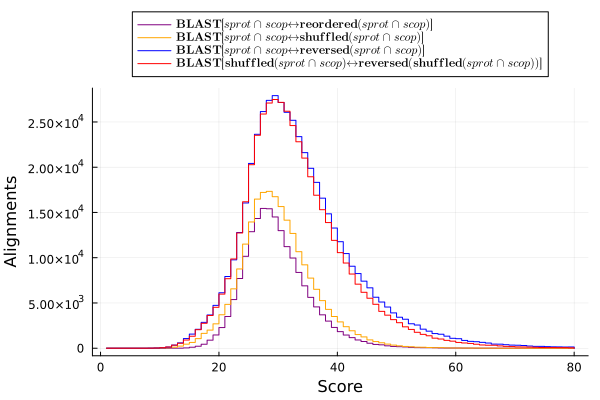

In [7]:
plot(xlabel="Score",
     ylabel="Alignments",
     legend=:outertop,
     dpi=500)
fig2plot!(scores[1], latexstring(BLAST(sprotscop, reorder(sprotscop))), colors[1])
fig2plot!(scores[2], latexstring(BLAST(sprotscop, shuf(sprotscop))), colors[2])
fig2plot!(scores[3], latexstring(BLAST(sprotscop, rev(sprotscop))), colors[3])
fig2plot!(scores[4], latexstring(BLAST(shuf(sprotscop), rev(shuf(sprotscop)))), colors[4])
savefig("figures/BLAST_SprotVariants.png")
plot!()